# Project Setup

### Importing the required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score,log_loss
from tabulate import tabulate
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Declaring the Variables

In [3]:
IMAGE_SIZE = [299,299]
BATCH_SIZE=16
CLASSES=["60-40","70-30","80-20","90-10","100-0"]
NUMBER_OF_CLASSES=len(CLASSES)

In [4]:
training_image_dir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Training'
testing_image_dir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Testing'
validation_image_dir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Validation'

### Fetching and Preprocessing the image files

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [6]:
training_image_data_set =tf.keras.utils.image_dataset_from_directory(
  training_image_dir,
  label_mode='int',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

Found 3908 files belonging to 5 classes.


In [7]:
validation_image_data_set=tf.keras.utils.image_dataset_from_directory(
    validation_image_dir,
    label_mode='int',
    seed=131,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 1467 files belonging to 5 classes.


In [8]:
testing_image_data_set=tf.keras.utils.image_dataset_from_directory(
    testing_image_dir,
    label_mode='int',
    seed=131,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 1445 files belonging to 5 classes.


In [9]:
print(f'Using {len(training_image_data_set)} sets for Training')
print(f'Using {len(validation_image_data_set)} sets for Validation')
print(f'Using {len(testing_image_data_set)} sets for Testing')

Using 245 sets for Training
Using 92 sets for Validation
Using 91 sets for Testing


In [10]:
normalized_training_set=training_image_data_set.map(lambda x,y: (normalization_layer(x), y))
normalized_validation_set=validation_image_data_set.map(lambda x,y: (normalization_layer(x), y))
normalized_testing_set=testing_image_data_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

# Training the Scracth Model

### Building the CNN Model

In [11]:
def Build_Model():
  model=Sequential()

  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(299,299,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dense(NUMBER_OF_CLASSES, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [12]:
# Summary of the model
model=Build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

### Peforming the 10 Fold Cross Validation

In [ ]:
# Logs
logdir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/003_Logs/10FoldCrossValidatedModel_Logs'

# Model Directory
model_dir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/004_Cross_Validated_Models/'

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
FOLDS=10
SCORES_PER_FOLD=[]

In [ ]:
TFold_start=time.time()

In [ ]:
i=0
j=24
k=216
for fold_var in range(0,FOLDS,1):
  print(f'Fold {fold_var+1}')
  print('--------------------------------------------------------------------------------------------')
  training_set1=normalized_training_set.take(i)
  training_set2=normalized_training_set.skip(i+j).take(k)
  training_set=training_set1.concatenate(training_set2)
  validation_set=normalized_training_set.skip(i).take(j)
  i=i+24
  j=24
  k=k-24

  model=Build_Model()
  Model_Run = model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    callbacks=[tensorboard_callback]
  )
  print('\n')
  print(f'Evaluating the model')
  print('\n')
  cur_scores=model.evaluate(validation_set)
  cur_scores[0]*=100
  cur_scores[1]*=100
  cur_scores=[fold_var+1,cur_scores[0],cur_scores[1]]
  SCORES_PER_FOLD.append(cur_scores)

  model.save(model_dir+'model_'+str(fold_var+1)+'.h5')
  tf.keras.backend.clear_session()
  print('--------------------------------------------------------------------------------------------')

Fold 1
--------------------------------------------------------------------------------------------
Epoch 1/20
216/216 [==============================] - 670s 3s/step - loss: 0.5807 - accuracy: 0.7144
Epoch 2/20
216/216 [==============================] - 16s 65ms/step - loss: 0.4032 - accuracy: 0.8001
Epoch 3/20
216/216 [==============================] - 14s 59ms/step - loss: 0.5617 - accuracy: 0.7740
Epoch 4/20
216/216 [==============================] - 16s 66ms/step - loss: 0.2809 - accuracy: 0.8718
Epoch 5/20
216/216 [==============================] - 14s 58ms/step - loss: 0.2690 - accuracy: 0.8848
Epoch 6/20
216/216 [==============================] - 17s 71ms/step - loss: 0.2115 - accuracy: 0.8981
Epoch 7/20
216/216 [==============================] - 14s 60ms/step - loss: 0.2581 - accuracy: 0.8770
Epoch 8/20
216/216 [==============================] - 15s 60ms/step - loss: 0.2594 - accuracy: 0.8814
Epoch 9/20
216/216 [==============================] - 16s 67ms/step - loss: 0.2128 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------------------------------------------------------------------------------
Fold 2
--------------------------------------------------------------------------------------------
Epoch 1/20
216/216 [==============================] - 19s 77ms/step - loss: 0.5746 - accuracy: 0.7205
Epoch 2/20
216/216 [==============================] - 16s 72ms/step - loss: 0.3051 - accuracy: 0.8443
Epoch 3/20
216/216 [==============================] - 17s 76ms/step - loss: 0.3962 - accuracy: 0.8131
Epoch 4/20
216/216 [==============================] - 21s 96ms/step - loss: 0.3572 - accuracy: 0.8440
Epoch 5/20
216/216 [==============================] - 18s 82ms/step - loss: 0.3037 - accuracy: 0.8406
Epoch 6/20
216/216 [==============================] - 16s 72ms/step - loss: 0.5841 - accuracy: 0.7870
Epoch 7/20
216/216 [==============================] - 17s 78ms/step - loss: 0.2606 - accuracy: 0.8779
Epoch 8/20
216/216 [==============================] - 16s 72ms/step - loss: 0.2997 - accuracy

In [ ]:
TFold_stop=time.time()

In [ ]:
print(f'Time required for 10 Fold Cross Validation= {TFold_stop-TFold_start} seconds')

Time required for 10 Fold Cross Validation= 6295.401615142822 seconds


In [ ]:
column_headers=['Fold Number','Validation Loss(%)','Validation Accuracy(%)']
print('10 Fold Cross Validation Result')
print(tabulate(SCORES_PER_FOLD, headers=column_headers, tablefmt="grid"))

10 Fold Cross Validation Result
+---------------+----------------------+--------------------------+
|   Fold Number |   Validation Loss(%) |   Validation Accuracy(%) |
+===============+======================+==========================+
|             1 |              4.00152 |                  99.2188 |
+---------------+----------------------+--------------------------+
|             2 |             22.8981  |                  88.8021 |
+---------------+----------------------+--------------------------+
|             3 |             12.5592  |                  95.8333 |
+---------------+----------------------+--------------------------+
|             4 |              6.51735 |                  98.4375 |
+---------------+----------------------+--------------------------+
|             5 |             18.3899  |                  91.4062 |
+---------------+----------------------+--------------------------+
|             6 |             15.161   |                  94.0104 |
+---------------

### Selecting the model with highest accuracy for training

In [ ]:
max_acc=SCORES_PER_FOLD[0][2]
max_acc_index=[]
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]>max_acc):
    max_acc=SCORES_PER_FOLD[i][2]
print(f'The maximum validation accuracy is: {max_acc}')
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]==max_acc):
    max_acc_index.append(i)
print(f'The folds having {max_acc} validation accuracy are:')
for i in range(len(max_acc_index)):
  print(max_acc_index[i]+1)

result=-1
if(len(max_acc_index)>1):
    min_loss=SCORES_PER_FOLD[max_acc_index[0]][1]
    j=0
    result=max_acc_index[0]
    while(j<len(max_acc_index)):
      index=max_acc_index[j]
      if(SCORES_PER_FOLD[index][1]<min_loss):
        min_loss=SCORES_PER_FOLD[index][1]
        result=index
      j+=1
else:
  result=max_acc_index[0]
print(f'Selecting the model of fold no {result+1} for fine parameter tuning')
model=load_model(model_dir+'model_'+str(result+1)+'.h5')

The maximum validation accuracy is: 99.21875
The folds having 99.21875 validation accuracy are:
1
Selecting the model of fold no 1 for fine parameter tuning


### Training the model for fine parameter tuning

In [ ]:
# Log Directory
scratch_model_logdir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/003_Logs/ScratchModel_Logs'

# Fine tuned Model Directory
scratch_model_dir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/005_Fine_Tuned_Model/FineTuned_Model.h5'

# Generated Data Diagrams Directory
scratch_model_loss='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ScratchModel/Loss'
scratch_model_accuracy='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ScratchModel/Accuracy'
scratch_model_rocauc='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ScratchModel/Roc_Auc'
scratch_model_rocauc_zoomed='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ScratchModel/Roc_Auc_Zoomed'
scratch_model_confusion_matrix='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ScratchModel/Confusion_Matrix'

In [ ]:
scratch_model_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=scratch_model_logdir)

In [ ]:
Training_start=time.time()

In [ ]:
Cur_Model_Run = model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[scratch_model_tensorboard_callback]
  )

Epoch 1/30
245/245 [==============================] - 340s 1s/step - loss: 1.3020 - accuracy: 0.8252 - val_loss: 0.3248 - val_accuracy: 0.8078
Epoch 2/30
245/245 [==============================] - 28s 115ms/step - loss: 0.1822 - accuracy: 0.9204 - val_loss: 0.0927 - val_accuracy: 0.9823
Epoch 3/30
245/245 [==============================] - 24s 95ms/step - loss: 0.1104 - accuracy: 0.9519 - val_loss: 0.0963 - val_accuracy: 0.9509
Epoch 4/30
245/245 [==============================] - 20s 81ms/step - loss: 0.1288 - accuracy: 0.9509 - val_loss: 0.1440 - val_accuracy: 0.9284
Epoch 5/30
245/245 [==============================] - 24s 94ms/step - loss: 0.1169 - accuracy: 0.9552 - val_loss: 0.0708 - val_accuracy: 0.9693
Epoch 6/30
245/245 [==============================] - 20s 81ms/step - loss: 0.1119 - accuracy: 0.9570 - val_loss: 0.0822 - val_accuracy: 0.9734
Epoch 7/30
245/245 [==============================] - 30s 120ms/step - loss: 0.1076 - accuracy: 0.9583 - val_loss: 0.1757 - val_accuracy

In [ ]:
Training_stop=time.time()

In [ ]:
print(f'Time required for model fine parameter tuning= {Training_stop-Training_start} seconds')

Time required for model fine parameter tuning= 1380.0513455867767 seconds


### Saving the fine tuned model

In [ ]:
model.save(scratch_model_dir)

### Plotting the performance of the model after fine parameter tuning

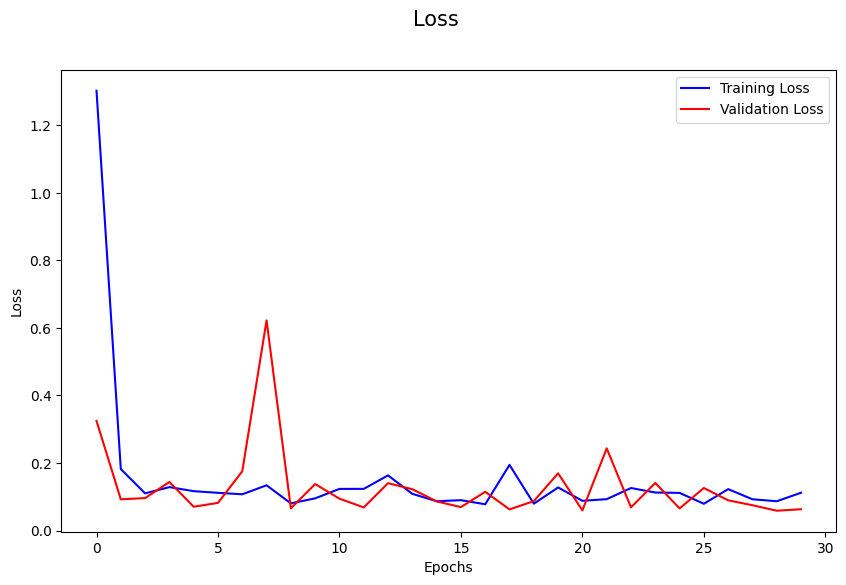

In [ ]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(Cur_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(Cur_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig(scratch_model_loss + '.eps', format='eps', dpi=600)
fig.savefig(scratch_model_loss + '.png', format='png', dpi=600)

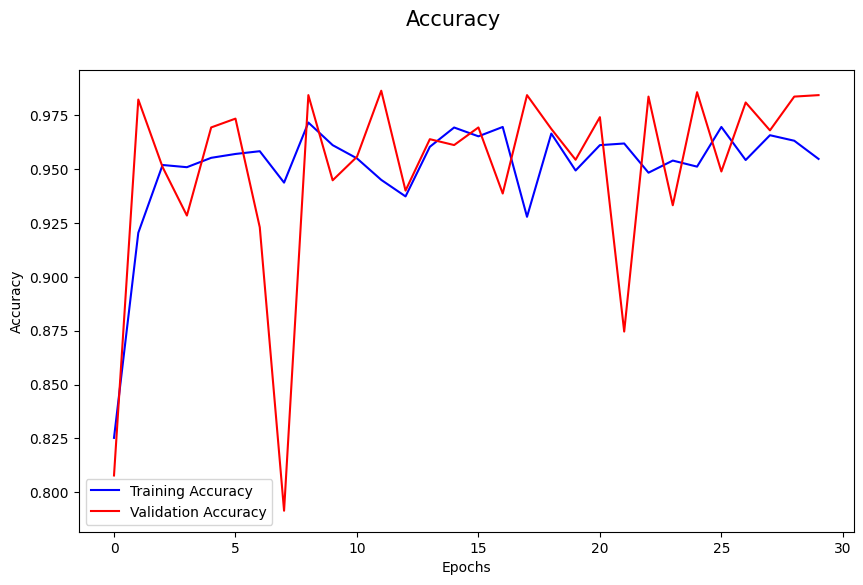

In [ ]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(Cur_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(Cur_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig(scratch_model_accuracy + '.eps', format='eps', dpi=600)
fig.savefig(scratch_model_accuracy + '.png', format='png', dpi=600)

### Calcualting Precision, Recall, Accuracy, F Score, Cohen-Kappa Score,ROC AUC and Log-Loss Score of the Model

In [ ]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [ ]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 20ms/step


In [ ]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [ ]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [ ]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [ ]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3, 4])

In [ ]:
#Calcualting the fpr, tpr and auc


fpr = [0] * NUMBER_OF_CLASSES
tpr = [0] * NUMBER_OF_CLASSES
roc_auc= [0] * NUMBER_OF_CLASSES
avg_roc_auc=0
for i in range(NUMBER_OF_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
roc_auc_details=[]
for i in range(NUMBER_OF_CLASSES):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [ ]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |  1        |
+---------+-----------+
| 70-30   |  0.999946 |
+---------+-----------+
| 80-20   |  0.995242 |
+---------+-----------+
| 90-10   |  0.996857 |
+---------+-----------+
| 100-0   |  1        |
+---------+-----------+


In [ ]:
avg_roc_auc=sum(roc_auc)/NUMBER_OF_CLASSES

In [ ]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.9984090710763038


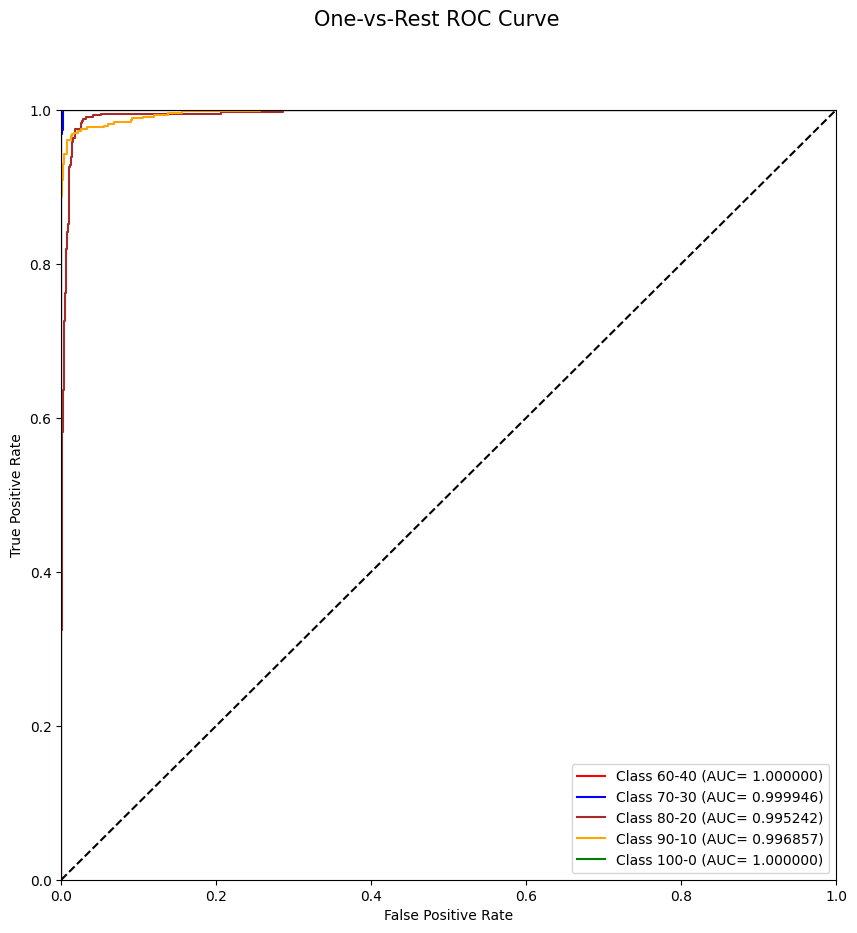

In [ ]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(scratch_model_rocauc + '.eps', format='eps', dpi=600)
fig.savefig(scratch_model_rocauc + '.png', format='png', dpi=600)

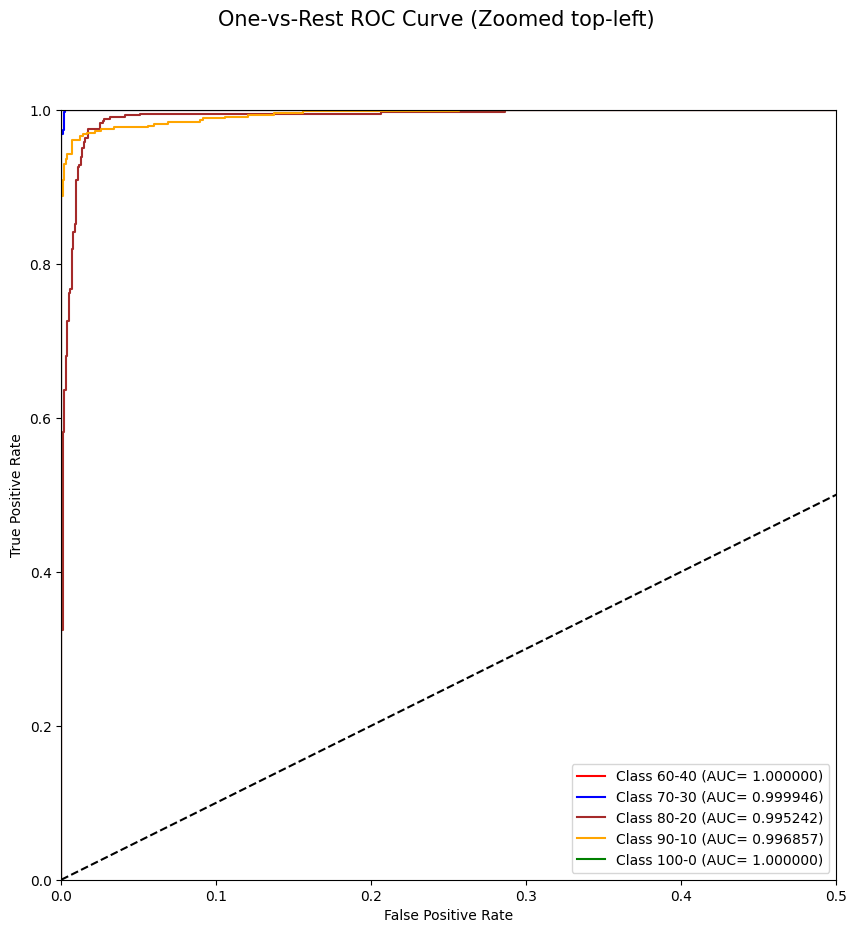

In [ ]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(scratch_model_rocauc_zoomed + '.eps', format='eps', dpi=600)
fig.savefig(scratch_model_rocauc_zoomed + '.png', format='png', dpi=600)

In [ ]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*NUMBER_OF_CLASSES
loss=[0]*NUMBER_OF_CLASSES
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(NUMBER_OF_CLASSES):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [ ]:
log_loss_result=[]
for i in range(NUMBER_OF_CLASSES):
  log_loss_result.append([CLASSES[i],loss[i]])

In [ ]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |      2.24371e-06 |
+---------+------------------+
| 70-30   |      0.00256453  |
+---------+------------------+
| 80-20   |      0.0327066   |
+---------+------------------+
| 90-10   |      0.0536826   |
+---------+------------------+
| 100-0   |      1.10135e-07 |
+---------+------------------+


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 1.0, Recall: 1.0, Accuracy: 0.9771626591682434, F Score: 1.0, Cohen Kappa Score: 0.9700592786725495


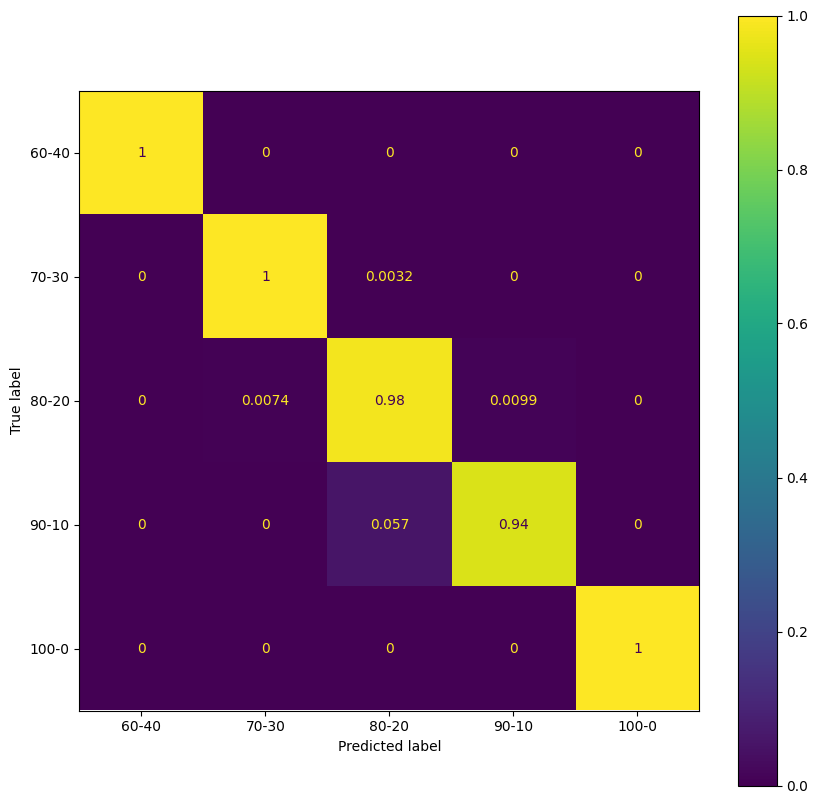

In [ ]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10","100-0"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig(scratch_model_confusion_matrix + '.eps', format='eps', dpi=600)
fig.savefig(scratch_model_confusion_matrix + '.png', format='png', dpi=600)

### Demonstrating how to use the model

In [ ]:
img=image.load_img('/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/001_Dataset_Turmeric/Testing/080t20s/80t20s_18.jpg',target_size=(299,299))

In [ ]:
x=image.img_to_array(img)

In [ ]:
x=x/255

In [ ]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 299, 299, 3)

In [ ]:
pred=model.predict(x)

1/1 [==============================] - 0s 351ms/step


In [ ]:
print(pred)

[[1.0806052e-08 8.0335246e-07 8.1281376e-01 1.8718489e-01 5.4785971e-07]]


In [ ]:
pred_name = CLASSES[np.argmax(pred)]
print(pred_name)

80-20


In [ ]:
temp_testing_set=normalized_testing_set.take(1)

pred_start=time.time()
for (images,labels) in (temp_testing_set):
  result=model.predict(images)
pred_stop=time.time()

1/1 [==============================] - 0s 63ms/step


In [ ]:
print(f'Time requrired for giving prediction on one set of {len(labels)} images= {pred_stop-pred_start}')
print(f'Average time requrired for giving prediction on one image= {(pred_stop-pred_start)/len(labels)}')

Time requrired for giving prediction on one set of 16 images= 0.8855211734771729
Average time requrired for giving prediction on one image= 0.0553450733423233


# Training the Pretrained Models

### Log Directories

In [13]:
# Vgg16
vgg16_logdir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/003_Logs/Vgg16_Logs'

# MobileNetV2
mobilenetv2_logdir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/003_Logs/MobileNetV2_Logs'

# ResNet50
resnet50_logdir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/003_Logs/ResNet50_Logs'

# EfficientNetB0
efficientnetb0_logdir='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/003_Logs/EfficientNetB0_Logs'


### Generated Data Diagrams Directories

In [14]:
# Vgg16
vgg16_loss='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/Vgg16/Loss'
vgg16_accuracy='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/Vgg16/Accuracy'
vgg16_rocauc='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/Vgg16/Roc_Auc'
vgg16_rocauc_zoomed='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/Vgg16/Roc_Auc_Zoomed'
vgg16_confusion_matrix='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/Vgg16/Confusion_Matrix'

# MobileNetV2
mobilenetv2_loss='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MobileNetV2/Loss'
mobilenetv2_accuracy='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MobileNetV2/Accuracy'
mobilenetv2_rocauc='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MobileNetV2/Roc_Auc'
mobilenetv2_rocauc_zoomed='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MobileNetV2/Roc_Auc_Zoomed'
mobilenetv2_confusion_matrix='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/MobileNetV2/Confusion_Matrix'

# ResNet50
resnet50_loss='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ResNet50/Loss'
resnet50_accuracy='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ResNet50/Accuracy'
resnet50_rocauc='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ResNet50/Roc_Auc'
resnet50_rocauc_zoomed='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ResNet50/Roc_Auc_Zoomed'
resnet50_confusion_matrix='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/ResNet50/Confusion_Matrix'

# EfficientNetB0
efficientnetb0_loss='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EfficientNetB0/Loss'
efficientnetb0_accuracy='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EfficientNetB0/Accuracy'
efficientnetb0_rocauc='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EfficientNetB0/Roc_Auc'
efficientnetb0_rocauc_zoomed='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EfficientNetB0/Roc_Auc_Zoomed'
efficientnetb0_confusion_matrix='/content/drive/MyDrive/Conference_Journal/2024_Journal_Turmeric_CNN_Work/006_Generated_Data_Diagrams/EfficientNetB0/Confusion_Matrix'

### Training the VGG16 Model and evaluating the performance

In [15]:
from keras.applications import VGG16

In [16]:
vgg16_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=vgg16_logdir)

In [17]:
vgg16_base=VGG16(weights='imagenet',include_top=False,input_shape=(299,299,3))
vgg16_model=Sequential()
vgg16_model.add(vgg16_base)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(NUMBER_OF_CLASSES,activation='softmax'))

vgg16_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

58889256/58889256 [==============================] - 3s 0us/step


In [18]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 5)                 207365    
                                                                 
Total params: 14922053 (56.92 MB)
Trainable params: 14922053 (56.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
vgg16_Training_start=time.time()

In [20]:
vgg16_Model_Run = vgg16_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[vgg16_tensorboard_callback]
  )

Epoch 1/30
245/245 [==============================] - 1566s 6s/step - loss: 1.6505 - accuracy: 0.1981 - val_loss: 1.6094 - val_accuracy: 0.1384
Epoch 2/30
245/245 [==============================] - 102s 415ms/step - loss: 1.6088 - accuracy: 0.2055 - val_loss: 1.6090 - val_accuracy: 0.2549
Epoch 3/30
245/245 [==============================] - 103s 419ms/step - loss: 1.6085 - accuracy: 0.2098 - val_loss: 1.6090 - val_accuracy: 0.2549
Epoch 4/30
245/245 [==============================] - 112s 455ms/step - loss: 1.6084 - accuracy: 0.2098 - val_loss: 1.6091 - val_accuracy: 0.2549
Epoch 5/30
245/245 [==============================] - 112s 456ms/step - loss: 1.6084 - accuracy: 0.2098 - val_loss: 1.6090 - val_accuracy: 0.2549
Epoch 6/30
245/245 [==============================] - 104s 421ms/step - loss: 1.6084 - accuracy: 0.2098 - val_loss: 1.6088 - val_accuracy: 0.2549
Epoch 7/30
245/245 [==============================] - 112s 455ms/step - loss: 1.6084 - accuracy: 0.2098 - val_loss: 1.6087 - v

In [21]:
vgg16_Training_stop=time.time()

In [22]:
print(f'Time required for VGG16 model training= {vgg16_Training_stop-vgg16_Training_start} seconds')

Time required for VGG16 model training= 5056.776744365692 seconds


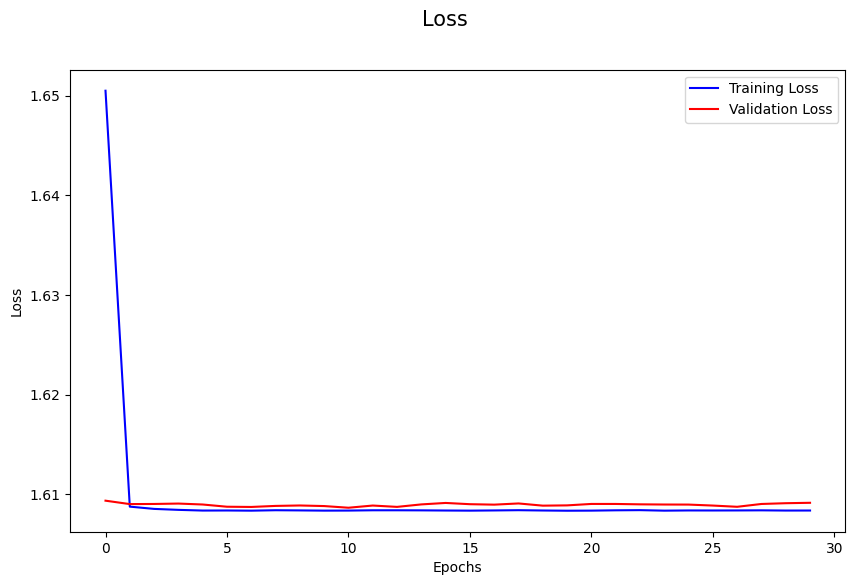

In [23]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(vgg16_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(vgg16_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig(vgg16_loss + '.eps', format='eps', dpi=600)
fig.savefig(vgg16_loss + '.png', format='png', dpi=600)

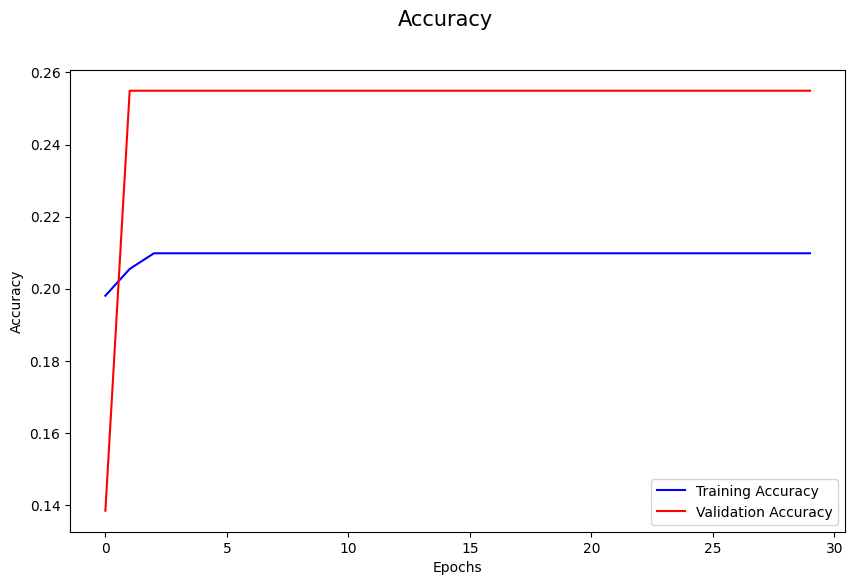

In [24]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(vgg16_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(vgg16_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig(vgg16_accuracy + '.eps', format='eps', dpi=600)
fig.savefig(vgg16_accuracy + '.png', format='png', dpi=600)

In [25]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [26]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(vgg16_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=vgg16_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 22ms/step


In [27]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [28]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [29]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [30]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3, 4])

In [31]:
#Calcualting the fpr, tpr and auc


fpr = [0] * NUMBER_OF_CLASSES
tpr = [0] * NUMBER_OF_CLASSES
roc_auc= [0] * NUMBER_OF_CLASSES
avg_roc_auc=0
for i in range(NUMBER_OF_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [32]:
roc_auc_details=[]
for i in range(NUMBER_OF_CLASSES):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [33]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |       0.5 |
+---------+-----------+
| 70-30   |       0.5 |
+---------+-----------+
| 80-20   |       0.5 |
+---------+-----------+
| 90-10   |       0.5 |
+---------+-----------+
| 100-0   |       0.5 |
+---------+-----------+


In [34]:
avg_roc_auc=sum(roc_auc)/NUMBER_OF_CLASSES

In [35]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.5


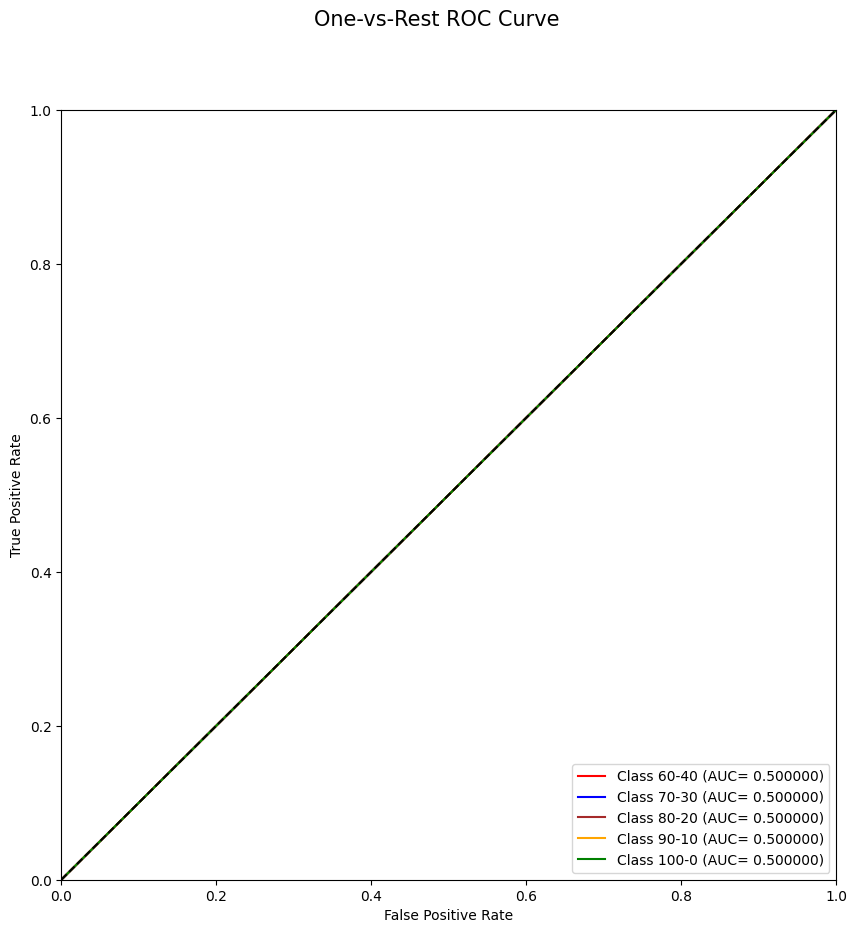

In [36]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(vgg16_rocauc + '.eps', format='eps', dpi=600)
fig.savefig(vgg16_rocauc + '.png', format='png', dpi=600)

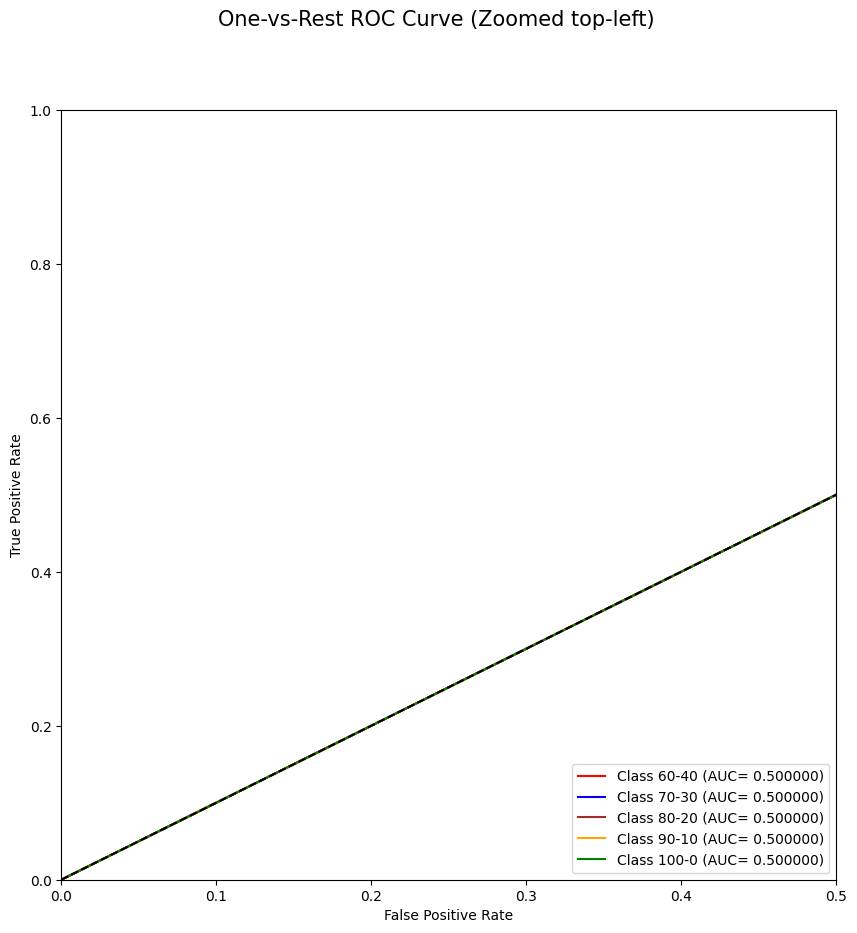

In [37]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(vgg16_rocauc_zoomed + '.eps', format='eps', dpi=600)
fig.savefig(vgg16_rocauc_zoomed + '.png', format='png', dpi=600)

In [38]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*NUMBER_OF_CLASSES
loss=[0]*NUMBER_OF_CLASSES
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(NUMBER_OF_CLASSES):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [39]:
log_loss_result=[]
for i in range(NUMBER_OF_CLASSES):
  log_loss_result.append([CLASSES[i],loss[i]])

In [40]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |         0.20214  |
+---------+------------------+
| 70-30   |         0.336785 |
+---------+------------------+
| 80-20   |         0.445534 |
+---------+------------------+
| 90-10   |         0.487363 |
+---------+------------------+
| 100-0   |         0.131437 |
+---------+------------------+


In [41]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.8816608786582947, Recall: 1.0, Accuracy: 0.21522490680217743, F Score: 0.9371091897908052, Cohen Kappa Score: 0.0


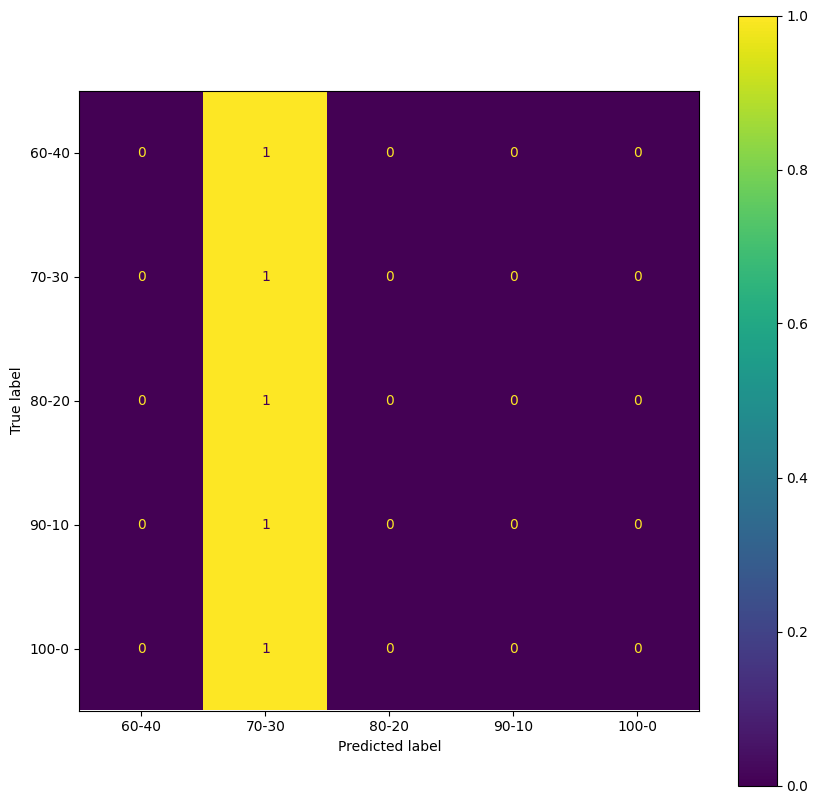

In [42]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10","100-0"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig(vgg16_confusion_matrix + '.eps', format='eps', dpi=600)
fig.savefig(vgg16_confusion_matrix + '.png', format='png', dpi=600)

### Training the  MobileNetV2 Model and evaluating the performance

In [43]:
from keras.applications import MobileNetV2

In [44]:
mobilenetv2_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=mobilenetv2_logdir)

In [45]:
mobilenetv2_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(299,299,3))
mobilenetv2_model=Sequential()
mobilenetv2_model.add(mobilenetv2_base)
mobilenetv2_model.add(Flatten())
mobilenetv2_model.add(Dense(NUMBER_OF_CLASSES,activation='softmax'))

mobilenetv2_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [46]:
mobilenetv2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 128000)            0         
                                                                 
 dense_3 (Dense)             (None, 5)                 640005    
                                                                 
Total params: 2897989 (11.05 MB)
Trainable params: 2863877 (10.92 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [47]:
mobilenetv2_Training_start=time.time()

In [48]:
mobilenetv2_Model_Run=mobilenetv2_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[mobilenetv2_tensorboard_callback]
)

Epoch 1/30
245/245 [==============================] - 75s 180ms/step - loss: 1.2950 - accuracy: 0.8385 - val_loss: 990.0781 - val_accuracy: 0.1384
Epoch 2/30
245/245 [==============================] - 38s 153ms/step - loss: 1.2121 - accuracy: 0.8815 - val_loss: 195.1277 - val_accuracy: 0.1357
Epoch 3/30
245/245 [==============================] - 43s 175ms/step - loss: 1.4194 - accuracy: 0.8905 - val_loss: 461.3974 - val_accuracy: 0.1384
Epoch 4/30
245/245 [==============================] - 43s 174ms/step - loss: 0.8323 - accuracy: 0.9102 - val_loss: 55.6818 - val_accuracy: 0.2658
Epoch 5/30
245/245 [==============================] - 43s 172ms/step - loss: 0.5878 - accuracy: 0.9212 - val_loss: 41.8220 - val_accuracy: 0.2549
Epoch 6/30
245/245 [==============================] - 39s 156ms/step - loss: 0.4476 - accuracy: 0.9161 - val_loss: 29.2474 - val_accuracy: 0.2549
Epoch 7/30
245/245 [==============================] - 43s 173ms/step - loss: 0.4121 - accuracy: 0.9307 - val_loss: 18.376

In [49]:
mobilenetv2_Training_stop=time.time()

In [50]:
print(f'Time required for MOBILENETV2 model training= {mobilenetv2_Training_stop-mobilenetv2_Training_start} seconds')

Time required for MOBILENETV2 model training= 1607.122888326645 seconds


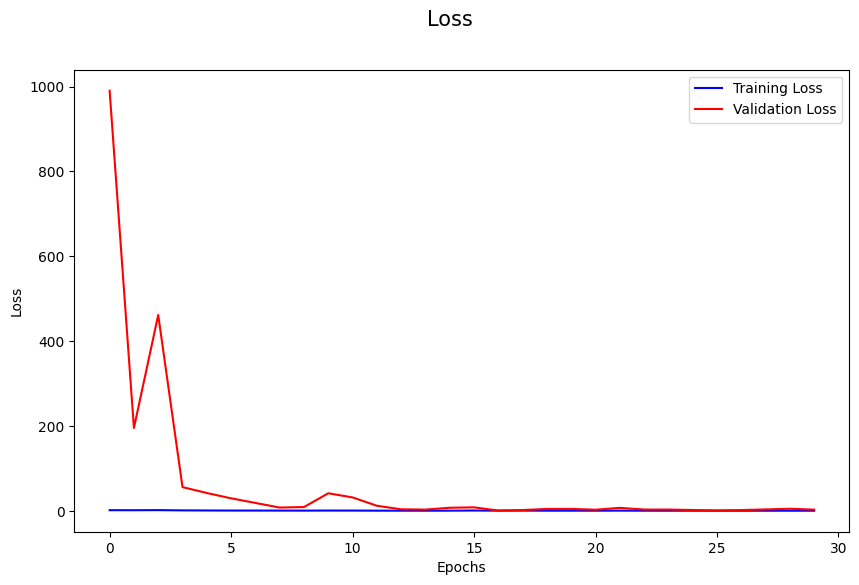

In [51]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(mobilenetv2_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(mobilenetv2_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig(mobilenetv2_loss + '.eps', format='eps', dpi=600)
fig.savefig(mobilenetv2_loss + '.png', format='png', dpi=600)

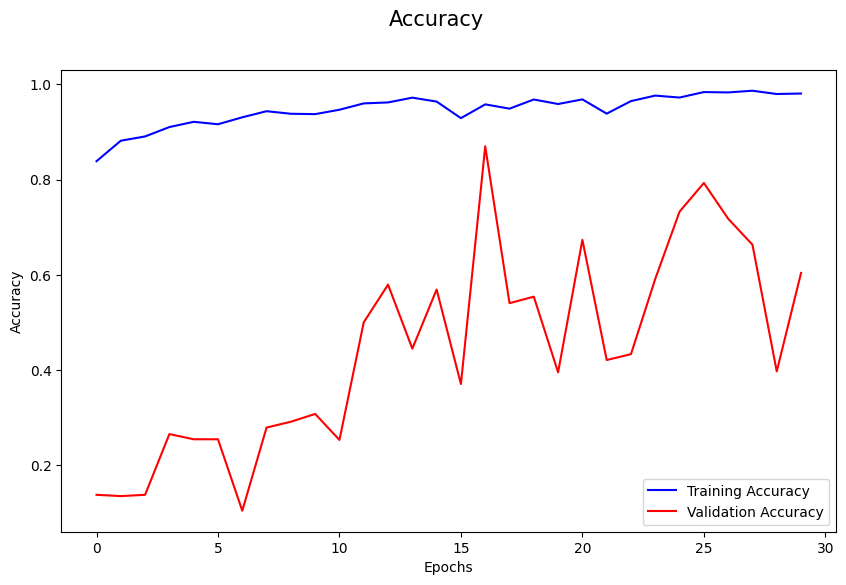

In [52]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(mobilenetv2_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(mobilenetv2_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig(mobilenetv2_accuracy + '.eps', format='eps', dpi=600)
fig.savefig(mobilenetv2_accuracy + '.png', format='png', dpi=600)

In [53]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [54]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(mobilenetv2_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=mobilenetv2_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 25ms/step


In [55]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [56]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [57]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [58]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3, 4])

In [59]:
#Calcualting the fpr, tpr and auc


fpr = [0] * NUMBER_OF_CLASSES
tpr = [0] * NUMBER_OF_CLASSES
roc_auc= [0] * NUMBER_OF_CLASSES
avg_roc_auc=0
for i in range(NUMBER_OF_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [60]:
roc_auc_details=[]
for i in range(NUMBER_OF_CLASSES):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [61]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |  1        |
+---------+-----------+
| 70-30   |  0.967239 |
+---------+-----------+
| 80-20   |  0.934486 |
+---------+-----------+
| 90-10   |  0.835078 |
+---------+-----------+
| 100-0   |  1        |
+---------+-----------+


In [62]:
avg_roc_auc=sum(roc_auc)/NUMBER_OF_CLASSES

In [63]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.9473605660165291


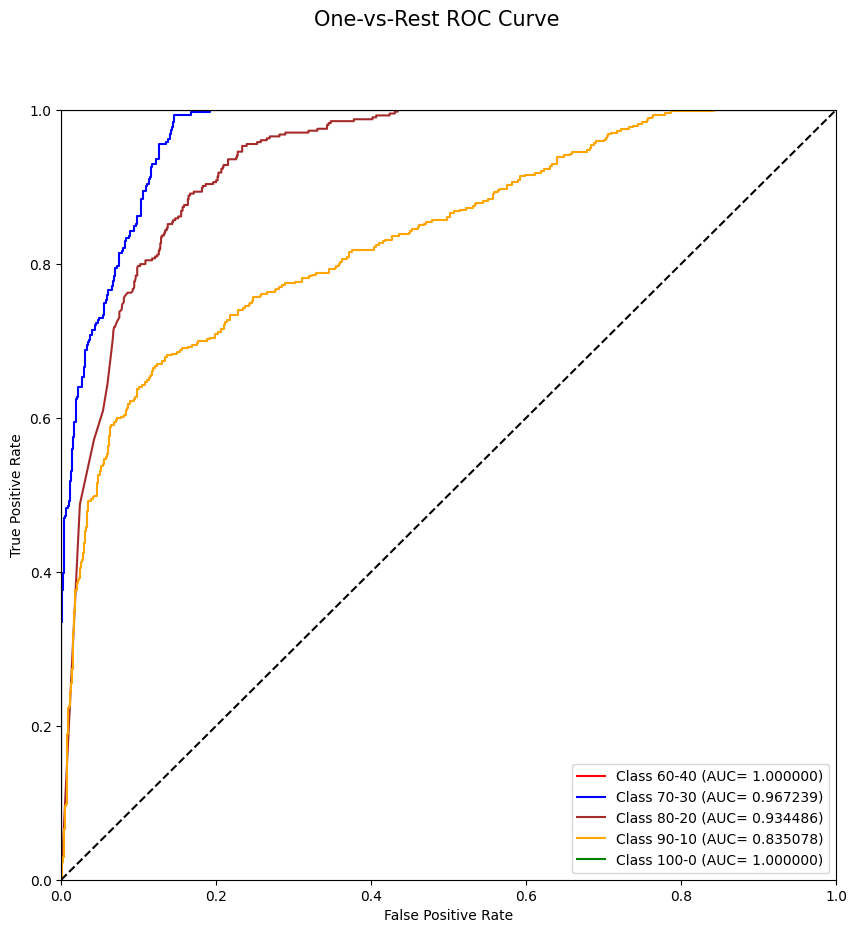

In [64]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(mobilenetv2_rocauc + '.eps', format='eps', dpi=600)
fig.savefig(mobilenetv2_rocauc + '.png', format='png', dpi=600)

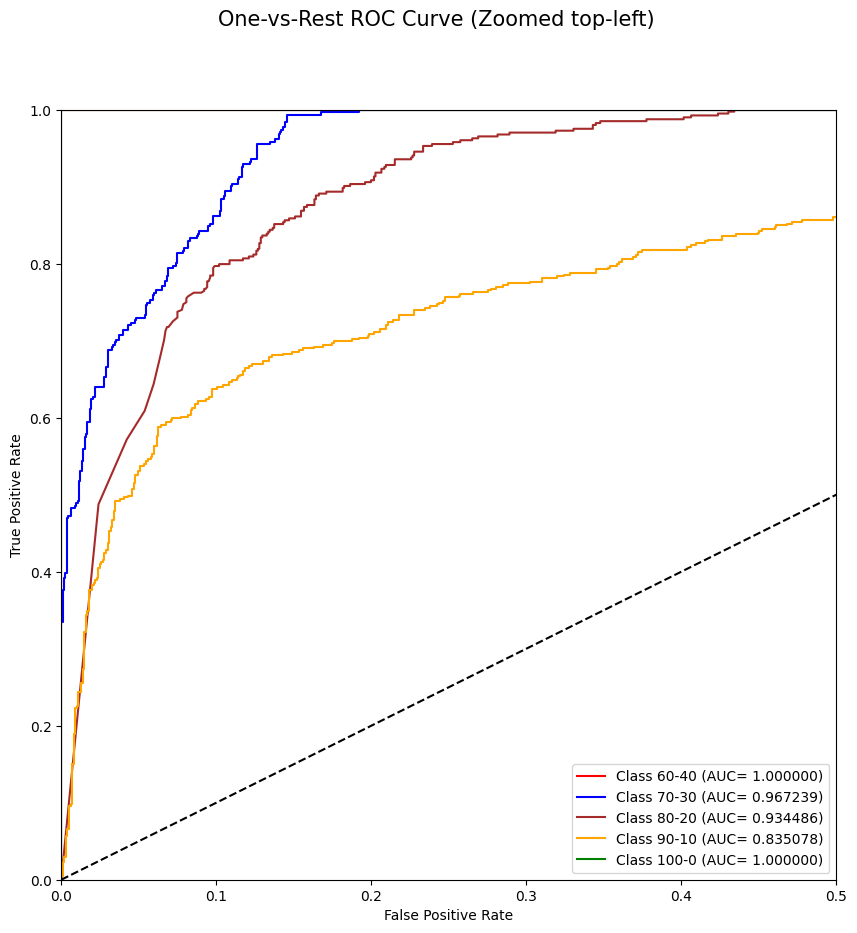

In [65]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(mobilenetv2_rocauc_zoomed + '.eps', format='eps', dpi=600)
fig.savefig(mobilenetv2_rocauc_zoomed + '.png', format='png', dpi=600)

In [66]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*NUMBER_OF_CLASSES
loss=[0]*NUMBER_OF_CLASSES
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(NUMBER_OF_CLASSES):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [67]:
log_loss_result=[]
for i in range(NUMBER_OF_CLASSES):
  log_loss_result.append([CLASSES[i],loss[i]])

In [68]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |       0.453237   |
+---------+------------------+
| 70-30   |       0.0155665  |
+---------+------------------+
| 80-20   |       0.00158689 |
+---------+------------------+
| 90-10   |       2.83104    |
+---------+------------------+
| 100-0   |      -0          |
+---------+------------------+


In [69]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.8871866464614868, Recall: 1.0, Accuracy: 0.5785467028617859, F Score: 0.9402214117241448, Cohen Kappa Score: 0.4444549660709112


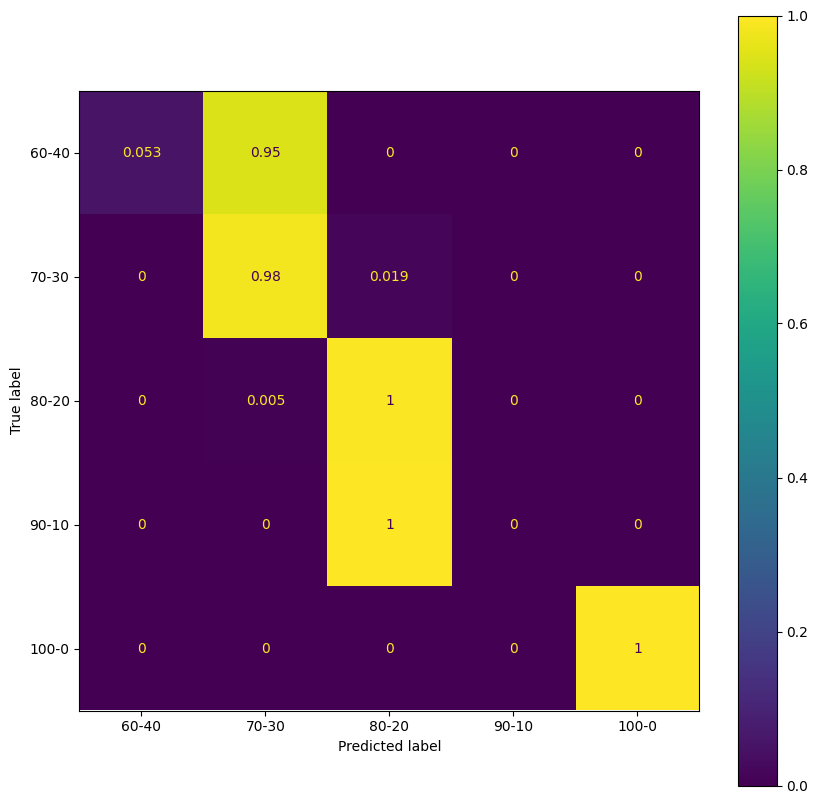

In [70]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10","100-0"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig(mobilenetv2_confusion_matrix + '.eps', format='eps', dpi=600)
fig.savefig(mobilenetv2_confusion_matrix + '.png', format='png', dpi=600)

### Training the ResNet50 Model and evaluating the performance

In [71]:
from keras.applications import ResNet50

In [72]:
resnet50_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=resnet50_logdir)

In [73]:
resnet50_base=ResNet50(weights='imagenet',include_top=False,input_shape=(299,299,3))
resnet50_model=Sequential()
resnet50_model.add(resnet50_base)
resnet50_model.add(Flatten())
resnet50_model.add(Dense(NUMBER_OF_CLASSES,activation='softmax'))

resnet50_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

94765736/94765736 [==============================] - 4s 0us/step


In [74]:
resnet50_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_3 (Flatten)         (None, 204800)            0         
                                                                 
 dense_4 (Dense)             (None, 5)                 1024005   
                                                                 
Total params: 24611717 (93.89 MB)
Trainable params: 24558597 (93.68 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [75]:
resnet50_Training_start=time.time()

In [76]:
resnet50_Model_Run=resnet50_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[resnet50_tensorboard_callback]
)

Epoch 1/30
245/245 [==============================] - 143s 413ms/step - loss: 2.7240 - accuracy: 0.7989 - val_loss: 16.1496 - val_accuracy: 0.2549
Epoch 2/30
245/245 [==============================] - 85s 347ms/step - loss: 2.0555 - accuracy: 0.8654 - val_loss: 5.6646 - val_accuracy: 0.2549
Epoch 3/30
245/245 [==============================] - 85s 346ms/step - loss: 1.0789 - accuracy: 0.8966 - val_loss: 8.2158 - val_accuracy: 0.2549
Epoch 4/30
245/245 [==============================] - 84s 340ms/step - loss: 0.5489 - accuracy: 0.9189 - val_loss: 3.8223 - val_accuracy: 0.2822
Epoch 5/30
245/245 [==============================] - 85s 347ms/step - loss: 0.4793 - accuracy: 0.9371 - val_loss: 4.9787 - val_accuracy: 0.4847
Epoch 6/30
245/245 [==============================] - 86s 349ms/step - loss: 0.2394 - accuracy: 0.9332 - val_loss: 1.2581 - val_accuracy: 0.7130
Epoch 7/30
245/245 [==============================] - 85s 345ms/step - loss: 0.2497 - accuracy: 0.9516 - val_loss: 0.6635 - val_

In [77]:
resnet50_Training_stop=time.time()

In [78]:
print(f'Time required for RESNET50 model training= {resnet50_Training_stop-resnet50_Training_start} seconds')

Time required for RESNET50 model training= 3575.71359539032 seconds


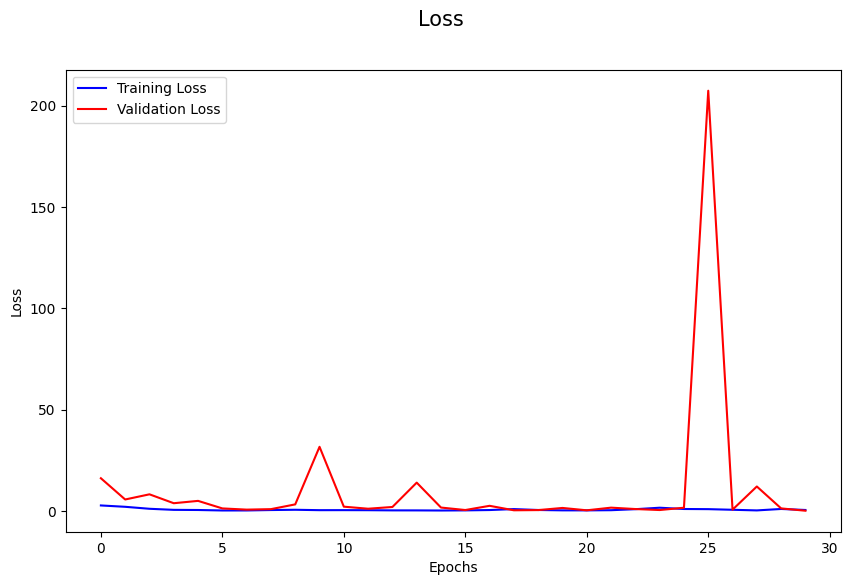

In [79]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(resnet50_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(resnet50_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig(resnet50_loss + '.eps', format='eps', dpi=600)
fig.savefig(resnet50_loss + '.png', format='png', dpi=600)

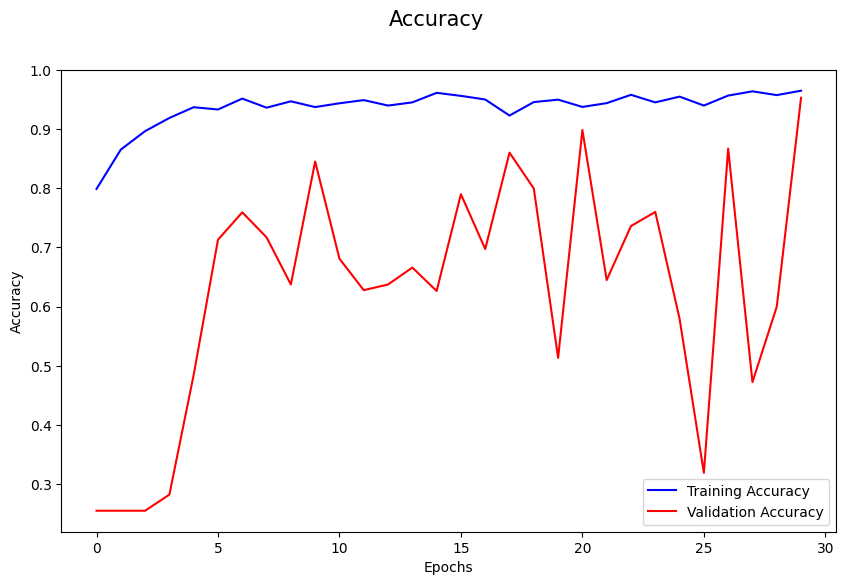

In [80]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(resnet50_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(resnet50_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig(resnet50_accuracy + '.eps', format='eps', dpi=600)
fig.savefig(resnet50_accuracy + '.png', format='png', dpi=600)

In [81]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [82]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(resnet50_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=resnet50_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 30ms/step


In [83]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [84]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [85]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [86]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3, 4])

In [87]:
#Calcualting the fpr, tpr and auc


fpr = [0] * NUMBER_OF_CLASSES
tpr = [0] * NUMBER_OF_CLASSES
roc_auc= [0] * NUMBER_OF_CLASSES
avg_roc_auc=0
for i in range(NUMBER_OF_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [88]:
roc_auc_details=[]
for i in range(NUMBER_OF_CLASSES):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [89]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |  1        |
+---------+-----------+
| 70-30   |  0.999966 |
+---------+-----------+
| 80-20   |  0.984749 |
+---------+-----------+
| 90-10   |  0.997056 |
+---------+-----------+
| 100-0   |  1        |
+---------+-----------+


In [90]:
avg_roc_auc=sum(roc_auc)/NUMBER_OF_CLASSES

In [91]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.9963542823147475


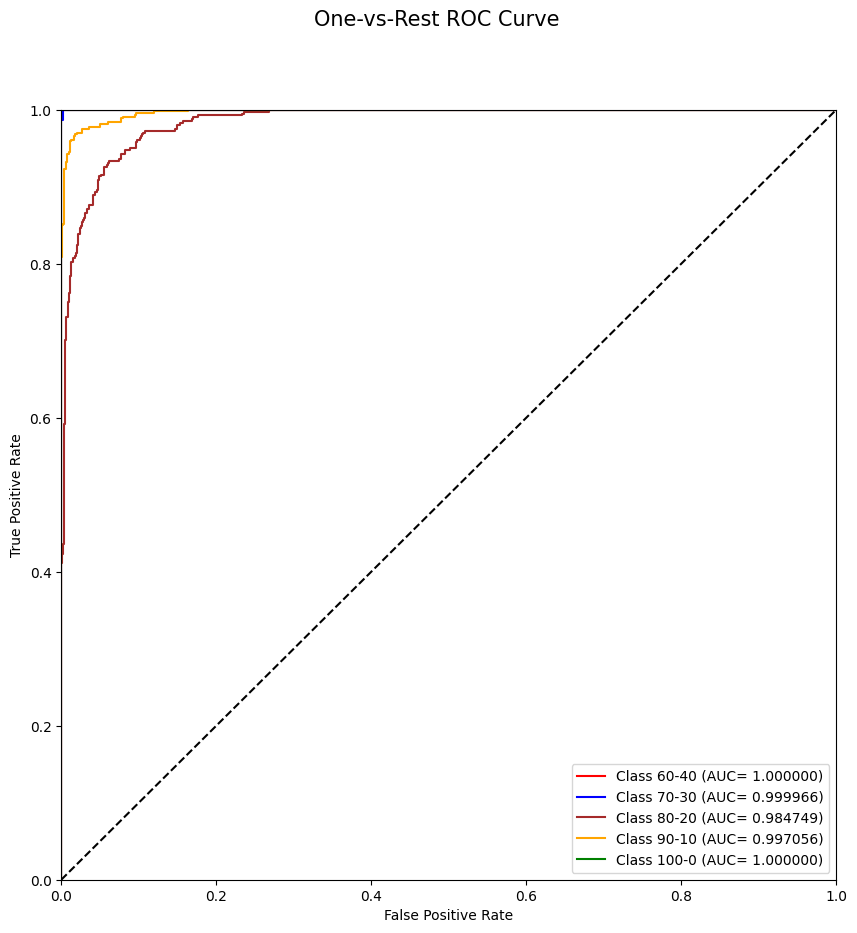

In [92]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(resnet50_rocauc + '.eps', format='eps', dpi=600)
fig.savefig(resnet50_rocauc + '.png', format='png', dpi=600)

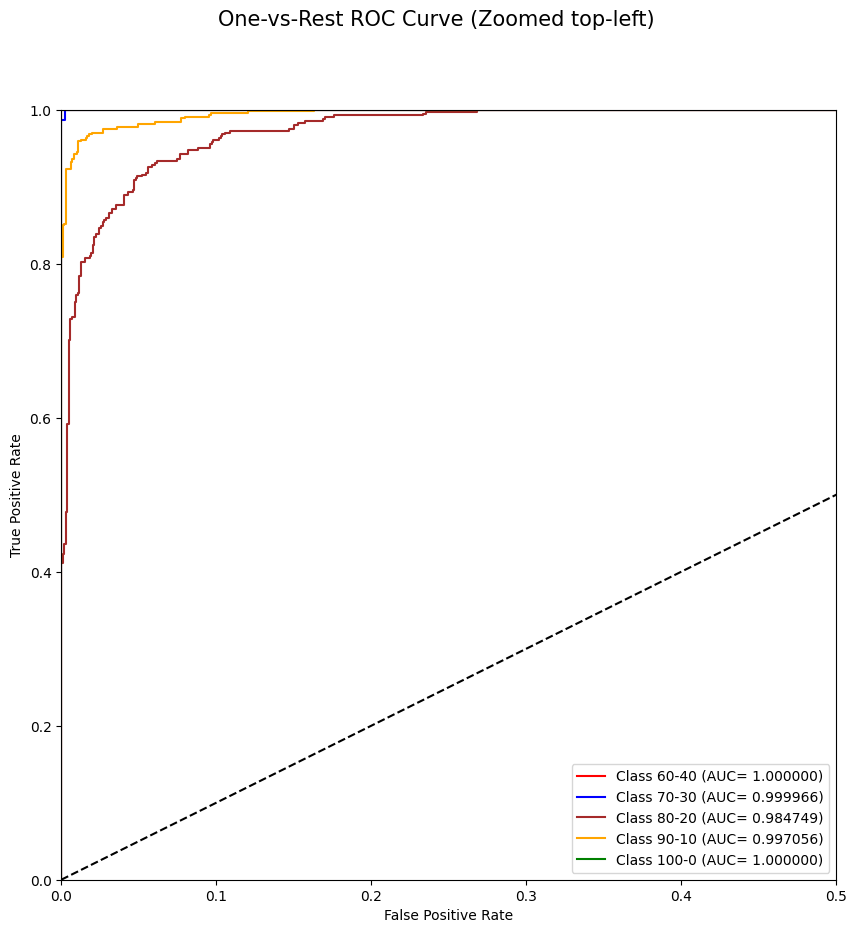

In [93]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(resnet50_rocauc_zoomed + '.eps', format='eps', dpi=600)
fig.savefig(resnet50_rocauc_zoomed + '.ong', format='png', dpi=600)

In [94]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*NUMBER_OF_CLASSES
loss=[0]*NUMBER_OF_CLASSES
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(NUMBER_OF_CLASSES):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [95]:
log_loss_result=[]
for i in range(NUMBER_OF_CLASSES):
  log_loss_result.append([CLASSES[i],loss[i]])

In [96]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |      5.98749e-05 |
+---------+------------------+
| 70-30   |      0.0289898   |
+---------+------------------+
| 80-20   |      0.128311    |
+---------+------------------+
| 90-10   |      0.00784714  |
+---------+------------------+
| 100-0   |     -0           |
+---------+------------------+


In [97]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 1.0, Recall: 1.0, Accuracy: 0.9356401562690735, F Score: 1.0, Cohen Kappa Score: 0.9153868869035888


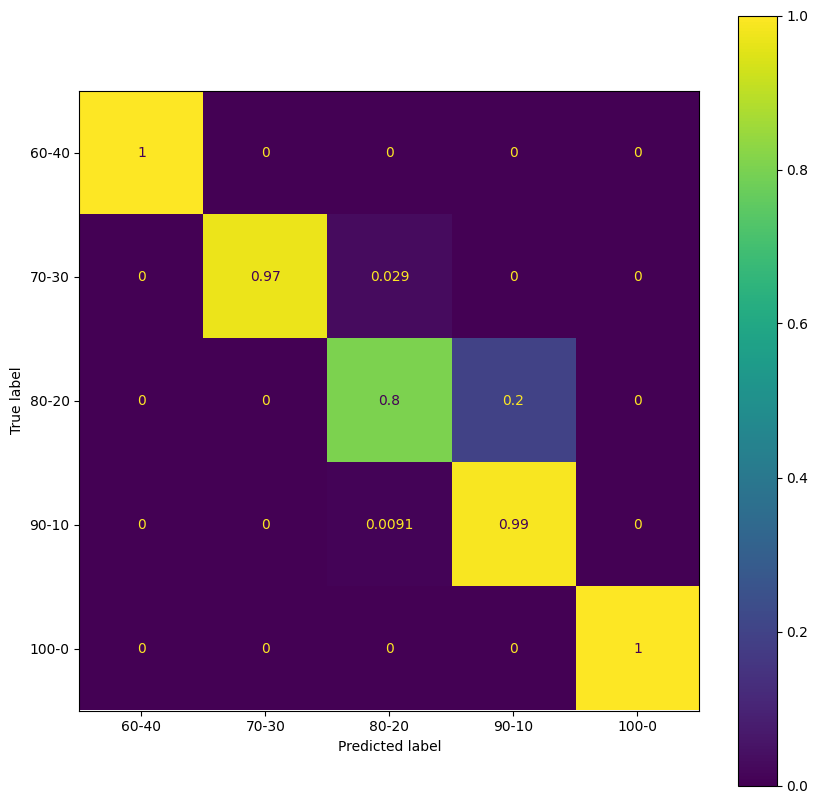

In [98]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10","100-0"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig(resnet50_confusion_matrix + '.eps', format='eps', dpi=600)
fig.savefig(resnet50_confusion_matrix + '.png', format='png', dpi=600)

### Training the EfficientNetB0 Model and evaluating the performance

In [99]:
from keras.applications import EfficientNetB0

In [100]:
efficientnetb0_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=efficientnetb0_logdir)

In [101]:
efficientnetb0_base=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(299,299,3))
efficientnetb0_model=Sequential()
efficientnetb0_model.add(efficientnetb0_base)
efficientnetb0_model.add(Flatten())
efficientnetb0_model.add(Dense(NUMBER_OF_CLASSES,activation='softmax'))

efficientnetb0_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


In [102]:
efficientnetb0_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 10, 10, 1280)      4049571   
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 128000)            0         
                                                                 
 dense_5 (Dense)             (None, 5)                 640005    
                                                                 
Total params: 4689576 (17.89 MB)
Trainable params: 4647553 (17.73 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [103]:
efficientnetb0_Training_start=time.time()

In [104]:
efficientnetb0_Model_Run=efficientnetb0_model.fit(
    normalized_training_set,
    validation_data=normalized_validation_set,
    epochs=30,
    validation_steps=len(normalized_validation_set),
    callbacks=[efficientnetb0_tensorboard_callback]
)

Epoch 1/30
245/245 [==============================] - 117s 304ms/step - loss: 2.4092 - accuracy: 0.8224 - val_loss: 35.3494 - val_accuracy: 0.2113
Epoch 2/30
245/245 [==============================] - 73s 298ms/step - loss: 2.3928 - accuracy: 0.8682 - val_loss: 45.3442 - val_accuracy: 0.2502
Epoch 3/30
245/245 [==============================] - 74s 299ms/step - loss: 1.2824 - accuracy: 0.9191 - val_loss: 44.3287 - val_accuracy: 0.2113
Epoch 4/30
245/245 [==============================] - 73s 296ms/step - loss: 1.4047 - accuracy: 0.9135 - val_loss: 22.4185 - val_accuracy: 0.1936
Epoch 5/30
245/245 [==============================] - 69s 280ms/step - loss: 1.0684 - accuracy: 0.9314 - val_loss: 64.5014 - val_accuracy: 0.1936
Epoch 6/30
245/245 [==============================] - 73s 294ms/step - loss: 1.0698 - accuracy: 0.9368 - val_loss: 11.4221 - val_accuracy: 0.2658
Epoch 7/30
245/245 [==============================] - 69s 282ms/step - loss: 0.7220 - accuracy: 0.9493 - val_loss: 67.1016 

In [105]:
efficientnetb0_Training_stop=time.time()

In [106]:
print(f'Time requied for EFFICIENTNETB0 model training= {efficientnetb0_Training_stop-efficientnetb0_Training_start} seconds')

Time requied for EFFICIENTNETB0 model training= 2351.1241738796234 seconds


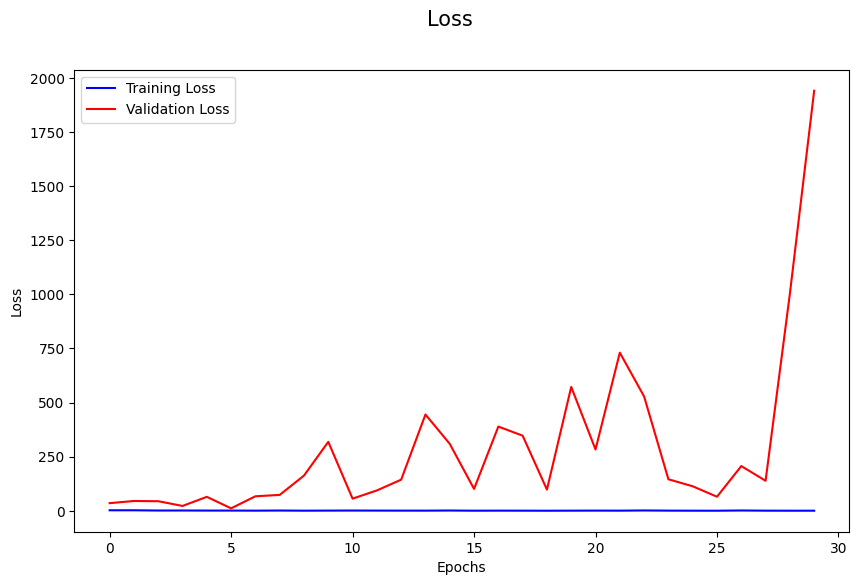

In [107]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(efficientnetb0_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(efficientnetb0_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig(efficientnetb0_loss + '.eps', format='eps', dpi=600)
fig.savefig(efficientnetb0_loss + '.png', format='png', dpi=600)

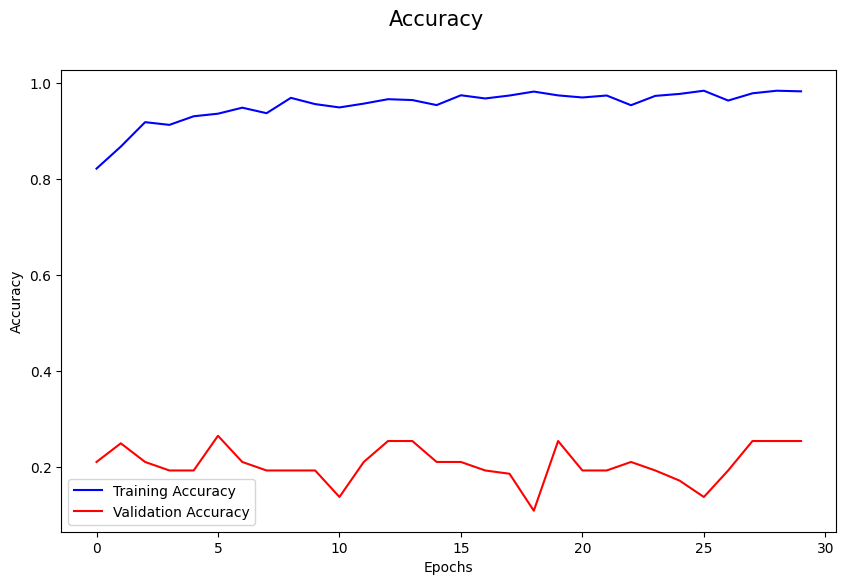

In [108]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(efficientnetb0_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(efficientnetb0_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig(efficientnetb0_accuracy + '.eps', format='eps', dpi=600)
fig.savefig(efficientnetb0_accuracy + '.png', format='png', dpi=600)

In [109]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [110]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(efficientnetb0_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=efficientnetb0_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 29ms/step


In [111]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [112]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [113]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [114]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3, 4])

In [115]:
#Calcualting the fpr, tpr and auc


fpr = [0] * NUMBER_OF_CLASSES
tpr = [0] * NUMBER_OF_CLASSES
roc_auc= [0] * NUMBER_OF_CLASSES
avg_roc_auc=0
for i in range(NUMBER_OF_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [116]:
roc_auc_details=[]
for i in range(NUMBER_OF_CLASSES):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [117]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 60-40   |       0.5 |
+---------+-----------+
| 70-30   |       0.5 |
+---------+-----------+
| 80-20   |       0.5 |
+---------+-----------+
| 90-10   |       0.5 |
+---------+-----------+
| 100-0   |       0.5 |
+---------+-----------+


In [118]:
avg_roc_auc=sum(roc_auc)/NUMBER_OF_CLASSES

In [119]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.5


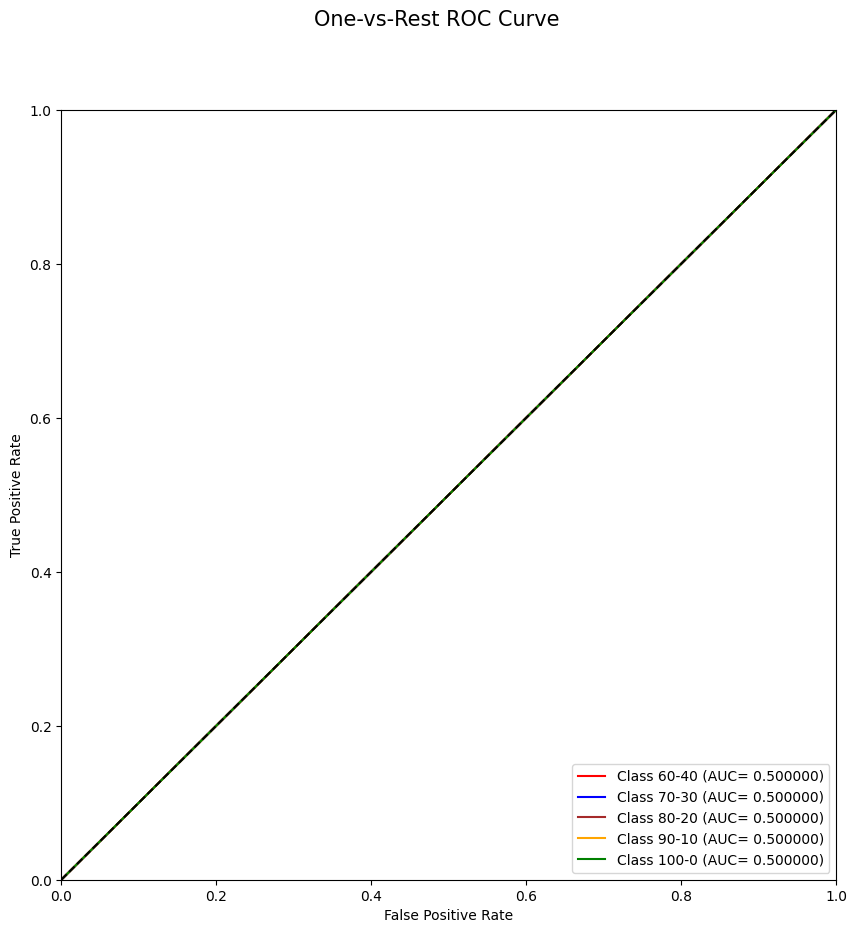

In [120]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(efficientnetb0_rocauc + '.eps', format='eps', dpi=600)
fig.savefig(efficientnetb0_rocauc + '.png', format='png', dpi=600)

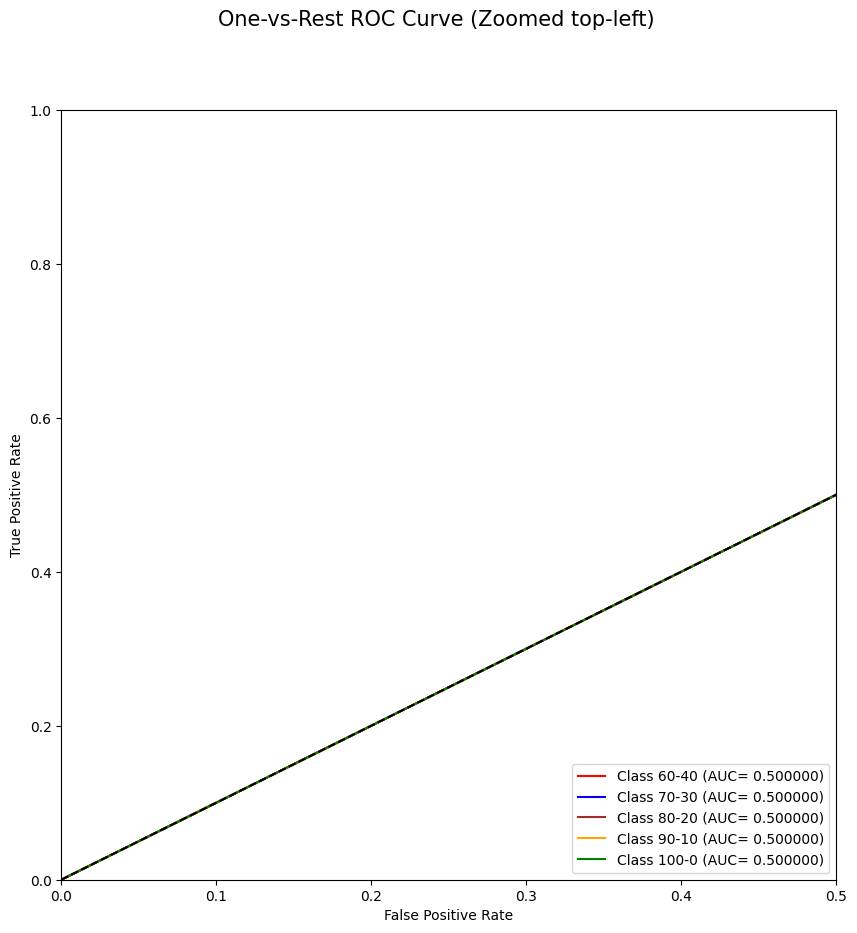

In [121]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange','green']
for i in range(NUMBER_OF_CLASSES):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig(efficientnetb0_rocauc_zoomed + '.eps', format='eps', dpi=600)
fig.savefig(efficientnetb0_rocauc_zoomed + '.png', format='png', dpi=600)

In [122]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*NUMBER_OF_CLASSES
loss=[0]*NUMBER_OF_CLASSES
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(NUMBER_OF_CLASSES):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [123]:
log_loss_result=[]
for i in range(NUMBER_OF_CLASSES):
  log_loss_result.append([CLASSES[i],loss[i]])

In [124]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 60-40   |          4.08729 |
+---------+------------------+
| 70-30   |         -0       |
+---------+------------------+
| 80-20   |          9.65652 |
+---------+------------------+
| 90-10   |         10.4931  |
+---------+------------------+
| 100-0   |          2.86827 |
+---------+------------------+


In [125]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.8816608786582947, Recall: 1.0, Accuracy: 0.21522490680217743, F Score: 0.9371091897908052, Cohen Kappa Score: 0.0


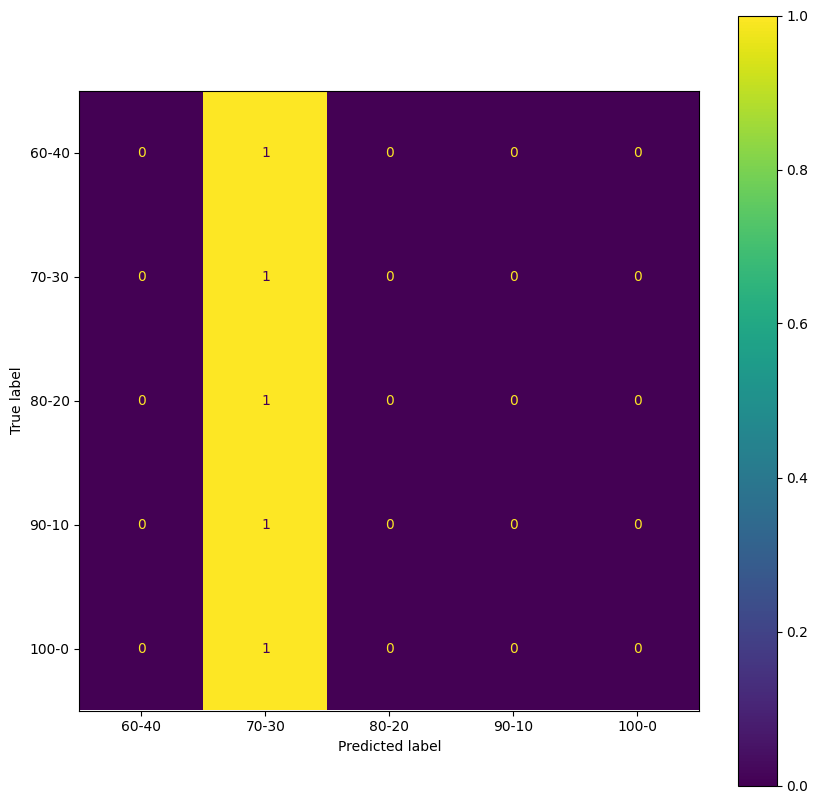

In [126]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["60-40","70-30","80-20","90-10","100-0"])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig(efficientnetb0_confusion_matrix + '.eps', format='eps', dpi=600)
fig.savefig(efficientnetb0_confusion_matrix + '.png', format='png', dpi=600)